In [87]:
import pandas as pd
import numpy as np
from scipy import stats

In [88]:
data = pd.read_csv("../../Data/Dataset_v0.csv",sep=";")

###  Catégoriser les types de variables :
 - Categorique ;
 - Numérique ;
 - Distance ;
 - Date

In [89]:
def categorisation(data,date_cols):
    distance = []
    date = []
    numerique = []
    categorique = []
    for col in data.columns:
        if data[col].dtypes == np.object:
            try:
                if str(type(eval(data[col][data[col].first_valid_index()]))) == "<class 'list'>":
                    distance.append(col)
                elif col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
            except:
                if col in date_cols:
                    date.append(col)
                else:
                    categorique.append(col)
                
            
        else :
            numerique.append(col)
                
    return dict({"numerique":numerique,"categorique":categorique,"date":date,"distance":distance})

In [90]:
feat_cat = categorisation(data,["Listing Date"])
feat_cat

{'numerique': ['price',
  'Listing Number',
  'Floor Size',
  'Price per m²',
  'Bathrooms',
  'Reception Rooms',
  'Erf Size',
  'Levies',
  'Rates and Taxes',
  'Bedrooms',
  'Kitchens',
  'Lounges',
  'Dining Rooms',
  'Gardens',
  'Coverage',
  'Office',
  'Domestic Rooms'],
 'categorique': ['name',
  'province',
  'city',
  'address',
  'Type of Property',
  'Street Address',
  'Bedroom',
  'Bathroom 1',
  'Bathroom 2',
  'Kitchen',
  'Other',
  'Parking',
  'Garden',
  'Pool',
  'Security',
  'No Transfer Duty',
  'Pets Allowed',
  'Lifestyle',
  'Bedroom 1',
  'Bedroom 2',
  'Bedroom 3',
  'Bedroom 4',
  'Bathroom 3',
  'Dining Room',
  'Garage',
  'Lounge',
  'Bathroom',
  'Special Features',
  'Nearby Public Transport',
  'Description',
  'Family/TV Room',
  'Garage 1',
  'Garage 2',
  'Temperature Control',
  'Style',
  'Facing',
  'Roof',
  'Wall',
  'Window',
  'Entrance Hall',
  'Rooms',
  'Special Feature',
  'Outbuilding',
  'Flatlet',
  'Standalone Building',
  'Interne

## 1) Traitement des valeurs manquantes

### traitement par colonne

In [91]:
missing = pd.DataFrame([data.isna().sum().values,(data.isna().sum()/data.shape[0]).values],index = ["valeurs manquantes","% valeurs manquantes"] , columns=data.columns)
missing

,name,price,province,city,address,Listing Number,Type of Property,Street Address,Listing Date,Floor Size,...,Special Feature,Outbuilding,Flatlet,Standalone Building,Office,Domestic Rooms,Internet Access,Wheelchair Accessible,Parking 1,Parking 2
valeurs manquantes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7859.000000,0.0,4748.000000,...,10158.000000,10546.000000,10498.000000,10181.000000,10596.000000,10353.000000,10378.000000,10618.000000,10682.000000,10682.000000
% valeurs manquantes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.695733,0.0,0.420326,...,0.899256,0.933605,0.929356,0.901292,0.938031,0.916519,0.918732,0.939979,0.945644,0.945644


In [92]:
missing.T.describe()

,valeurs manquantes,% valeurs manquantes
count,73.000000,73.000000
mean,7397.150685,0.654847
std,3634.772695,0.321775
min,0.000000,0.000000
25%,5418.000000,0.479639
50%,8813.000000,0.780188
75%,10274.000000,0.909525
max,10682.000000,0.945644


#### On va supprimer certaines variables par seuil de valeurs manquantes mais sauver quelques variables pertinents au niveau métier :


In [93]:
def drop_columns(data,keep,drop,seuil):    
    missing = pd.DataFrame([data.isna().sum().values,(data.isna().sum()/data.shape[0]).values],index = ["valeurs manquantes","% valeurs manquantes"] , columns=data.columns)
    missing_freq = missing.T[missing.T["% valeurs manquantes"]>=seuil]
    print(len(missing_freq["% valeurs manquantes"]))
    (len(missing_freq["% valeurs manquantes"])/data.shape[1])*100

    for i in missing_freq.T.columns:
        ## variable à sauver
        if i not in keep:
            drop.append(i)
            
    return data.drop(drop,axis=1)

In [94]:
must_keep = feat_cat["distance"]+['price','Bathrooms','Levies','Rates and Taxes','Bedrooms','Kitchens','Garage',"Gardens",'Pool','Pets Allowed']
must_drop = ['Listing Number','Price per m²']+feat_cat["date"]

In [95]:
data = drop_columns(data,must_keep,must_drop,0.40)

59


In [96]:
data.shape

(11296, 21)

### 2) Traitement des valeurs aberrantes

### Détection par z-score (mbola tsy mety)

https://towardsdatascience.com/z-score-for-anomaly-detection-d98b0006f510

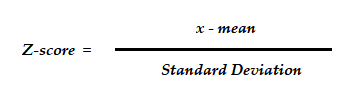


In [97]:
def z_score(data,columns,seuil):
    z_scores = stats.zscore(data[columns])
    print(z_scores)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < seuil).all(axis=1)
    data = data[filtered_entries]
    return data

### par IQR 

$$ IQR = Q3 - Q1 $$
$$ interval = [Q1 - seuil * IQR, Q3 + seuil * IQR]$$

In [98]:
def IQR(df,cols,quantiles=[0.25,0.75],seuil=1.5):
    Q1 = df[cols].quantile(quantiles[0])
    Q3 = df[cols].quantile(quantiles[1])
    IQR = Q3 - Q1

    return df[~((df[cols] < (Q1 - seuil * IQR)) |(df[cols] > (Q3 + seuil * IQR))).any(axis=1)]

Variables sur les prix (+ Listing Number) à ne pas vérifier : 
- 'price'

In [99]:
data.shape

(11296, 21)

In [100]:
feat_cat = categorisation(data,[""])
feat_cat

{'numerique': ['price',
  'Bathrooms',
  'Levies',
  'Rates and Taxes',
  'Bedrooms',
  'Kitchens',
  'Gardens'],
 'categorique': ['name',
  'province',
  'city',
  'address',
  'Type of Property',
  'Pool',
  'Pets Allowed',
  'Garage'],
 'date': [],
 'distance': ['Health',
  'Food and Entertainment',
  'Shopping',
  'Sports and Leisure',
  'Education',
  'Transport and Public Services']}

In [101]:
to_check = [ 'Bathrooms',
  'Levies',
  'Rates and Taxes',
  'Bedrooms',
  'Kitchens',
  'Gardens']

#data = z_score(data,to_check,1.)
data = IQR(data,to_check)
data.shape

(10019, 21)

### 3) Encodage :

- Pets Allowes en variable bool;
- Pool en variable bool;
- Garage en variable bool;
- Nan des variables catégoriques -> "missing"

In [102]:
data["Pets Allowed"].value_counts()

Yes    3252
No     1845
Name: Pets Allowed, dtype: int64

In [103]:
for pool in data["Pool"].value_counts().index:
    print(pool)

Yes
1
Communal Pool
Pool
Fenced, Communal Pool
Communal pool
Swimming pool
Chlorinator
Chlorine pool
Auto Cleaning Equipment
Splash Pool
Communal
Chlorine / swimming pool(s)
Chlorine
Safety Net
Communal swimming pool
Swimming
Fibreglass in Ground
Heated
Gunite in Ground
Own chlorine / swimming pool(s)
Fenced
Communal chlorine / swimming pool(s)
Own pool
Fibreglass in Ground, Auto Cleaning Equipment
Fibreglass in Ground, Safety Net, Auto Cleaning Equipment
Communal, Swimming
Auto Cleaning Equipment, Communal Pool
Auto Cleaning Equipment, Chlorinator
Splash pool
Auto Cleaning Equipment, Chlorinator, Communal Pool
Fenced, Auto Cleaning Equipment, Chlorinator, Communal Pool
Portapool
Own
Communal chlorine / swimming pool(s) with cleaner
Gunite in Ground, Communal Pool
Own swimming pool
Communal chlorine pool
Heated, Auto Cleaning Equipment
Gunite in Ground, Auto Cleaning Equipment
Communal Swimming Pool
Fibreglass in Ground, Auto Cleaning Equipment, Communal Pool
Heated, Communal Pool
Fenc

In [104]:
for col in data.columns:
    if col == "Pets Allowed":
        data[col] = data[col].replace(np.nan,"missing")
    elif col == "Pool":
        data[col] = data[col].replace(r".*","y",regex=True)
        data[col] = data[col].replace(r"yy","Yes",regex=True)
        data[col] = data[col].replace(np.nan,"missing")
    elif col == "Garage":
        data[col] = data[col].replace(r".*","y",regex=True)
        data[col] = data[col].replace(r"yy","Yes",regex=True)
        data[col] = data[col].replace(np.nan,"missing")
    else :
        data[col] = data[col].replace(np.nan,"missing")

In [105]:
data["Pets Allowed"].value_counts()

missing    4922
Yes        3252
No         1845
Name: Pets Allowed, dtype: int64

In [106]:
data["Pool"].value_counts()

missing    7765
Yes        2254
Name: Pool, dtype: int64

In [107]:
data.to_csv("../../Data/Dataset_v1.csv",sep=";",index=False)